# 1. train, test data load

In [0]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)

In [0]:
df_train = pd.read_csv("TMDB_train_col_remove.csv", engine='python', header=None)
df_test = pd.read_csv("TMDB_test_remove_col.csv", engine='python', header=None)

In [105]:
print(df_train.shape,df_test.shape)

(3000, 23) (4398, 22)


In [0]:
# train과 test 간의 데이터프레임 columns 수 맞춰주기 위해 일단 공갈 revenue를 df_test에 넣어줍니다
df_test.insert(len(df_test.columns), 'revenue', np.nan)

In [0]:
column_list = """id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue""".split(",")

In [0]:
df_train.columns = column_list
df_test.columns = column_list

## 2. feature selection & handling

In [0]:
df_train = df_train.drop(['id', 'belongs_to_collection', 'homepage', 'imdb_id', 'original_language', 'original_title', 'overview', 'poster_path', 'production_companies', 'release_date', 'runtime', 'status', 'tagline', 'Keywords', 'crew'], axis=1)
df_test = df_test.drop(['id', 'belongs_to_collection', 'homepage', 'imdb_id', 'original_language', 'original_title', 'overview', 'poster_path', 'production_companies', 'release_date', 'runtime', 'status', 'tagline', 'Keywords', 'crew'], axis=1)

In [0]:
# train 데이터 null이 있는 행은 제거
df_train = df_train.loc[~df_train['genres'].isna()]
df_train = df_train.loc[~df_train['production_countries'].isna()]
df_train = df_train.loc[~df_train['spoken_languages'].isna()]
df_train = df_train.loc[~df_train['cast'].isna()]

In [0]:
# Test 데이터 null이 있는 행은 제거
df_test = df_test.loc[~df_test['genres'].isna()]
df_test = df_test.loc[~df_test['production_countries'].isna()]
df_test = df_test.loc[~df_test['spoken_languages'].isna()]
df_test = df_test.loc[~df_test['cast'].isna()]

In [0]:
# null 제거 뒤 reindex
df_train = df_train.reset_index().drop('index', axis = 1)
df_test = df_test.reset_index().drop('index', axis = 1)

In [0]:
# 데이터가 모두 스트링 타입으로 기입되어 있다. 고유 데이터 타입으로 전환
import ast

def literal_return(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError) as e:
        return val


df_train['genres'] = df_train['genres'].apply(literal_return)
df_train['production_countries'] = df_train['production_countries'].apply(literal_return)
df_train['spoken_languages'] = df_train['spoken_languages'].apply(literal_return)
df_train['cast'] = df_train['cast'].apply(literal_return)


df_test['genres'] = df_test['genres'].apply(literal_return)
df_test['production_countries'] = df_test['production_countries'].apply(literal_return)
df_test['spoken_languages'] = df_test['spoken_languages'].apply(literal_return)
df_test['cast'] = df_test['cast'].apply(literal_return)


### production countries

1. dict 벗겨내서 첫 번재 국가로 변환

2. 북미, 유럽, 기타 국가로 카테고리 지정 (value_counts 를 통해 자주 나오는 국가만 임의로 취합했습니다)

In [0]:
df_train['production_countries'] = pd.Series(item[0]['iso_3166_1'] for item in df_train['production_countries'])
df_test['production_countries'] = pd.Series(item[0]['iso_3166_1'] for item in df_test['production_countries'])

In [0]:
def categrize_country(country):
    if country in (['US', 'CA']):
        return 'north_america'
    elif country in (['GB', 'FR', 'DE', 'RU', 'ES', 'IT']):  # 영 프 독 러 스페인 이탈리아
        return 'europe'
    elif country in (['IN', 'in']):
        return 'india'
    else:
        return 'etc'


# 카테고리로 구분하는 칼럼 만들기

df_train['production_counties_cate'] = df_train['production_countries'].apply(categrize_country)

df_test['production_counties_cate'] = df_test['production_countries'].apply(categrize_country)


In [116]:
df_train['production_counties_cate'].value_counts()

north_america    1898
europe            580
etc               364
india              77
Name: production_counties_cate, dtype: int64

## spoken_languages

1. production countries 칼럼과 비슷하지만 다름 (소문자 사용)
2. 절대다수 영어이기 때문에 영어와 그 외로 구분

In [0]:
df_train['spoken_languages'] = pd.Series(item[0]['iso_639_1'] for item in df_train['spoken_languages'])

df_test['spoken_languages'] = pd.Series(item[0]['iso_639_1'] for item in df_test['spoken_languages'])



def categrize_language(lan):
    if lan == 'en':
        return 'en'
    else:
        return 'etc'



# 카테고리로 구분하는 칼럼 만들기

df_train['spoken_languages_cate'] = df_train['spoken_languages'].apply(categrize_language)


df_test['spoken_languages_cate'] = df_test['spoken_languages'].apply(categrize_language)



In [118]:
df_train['spoken_languages_cate'].value_counts()

en     2331
etc     588
Name: spoken_languages_cate, dtype: int64

## 장르 dict 벗겨내서 인코딩 칼럼으로 

In [0]:
# 장르를 원핫인코딩 형태로 칼럼으로 전환 (더미변수)


for num, temp_list in enumerate(df_train['genres']):
    for genre_dict in temp_list:
        try:
            df_train.insert(0, f"genre_{genre_dict['name']}", np.nan)
            df_train.loc[df_train.index == num, f"genre_{genre_dict['name']}"] = 1
        except:
            pass

        
for num, temp_list in enumerate(df_test['genres']):
    for genre_dict in temp_list:
        try:
            df_test.insert(0, f"genre_{genre_dict['name']}", np.nan)
            df_test.loc[df_test.index == num, f"genre_{genre_dict['name']}"] = 1
        except:
            pass

In [120]:
# 코미디 장르인 1번 영화는 genre_Comedy 칼럼에 1.0 있고 나머진 NaN
# 장르가 여러개면 여러 칼럼에 1.0 표기됨

df_train.head(1)

,genre_TV Movie,genre_History,genre_Documentary,genre_Western,genre_War,genre_Fantasy,genre_Animation,genre_Foreign,genre_Mystery,genre_Science Fiction,genre_Crime,genre_Adventure,genre_Music,genre_Horror,genre_Action,genre_Thriller,genre_Romance,genre_Family,genre_Drama,genre_Comedy,budget,genres,popularity,production_countries,spoken_languages,title,cast,revenue,production_counties_cate,spoken_languages_cate
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,14000000,"[{'id': 35, 'name': 'Comedy'}]",6.575393,US,en,Hot Tub Time Machine 2,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...",12314651,north_america,en


## 영화예산 (budget)으로 등급 만들기
-> 회귀에 사용해도 되지만, 캐스팅 배우를 등급 나누기 위해 만들었습니다

In [0]:
# 영화 예산을 자체적으로 3등분
# 상위 25% 는 3점 ... 이런 식으로

def budget_level(budget):
    budget_list = df_train['budget'].tolist()
    q1, q3 = np.percentile(budget_list, [25, 75])
    if budget > q3:
        return 3
    elif q1 < budget <= q3:
        return 2
    else:
        return 1

df_train['budget_level'] = df_train['budget'].apply(budget_level)

df_test['budget_level'] = df_test['budget'].apply(budget_level)


## 출연 배우 (cast) 전처리

In [0]:
# 캐스팅 배우 전처리 방식 1 - 일단 규모로 파악하기

df_train['casting_size'] = pd.Series(len(temp_list) for temp_list in df_train['cast'])

df_test['casting_size'] = pd.Series(len(temp_list) for temp_list in df_test['cast'])


캐스팅 배우 전처리 방식 2 - 비싼 영화에 출연했는지 여부로 배우 등급 먹이기


step 1. cast의 dict를 벗겨내서 주요 출연자만 5명 가량 뽑히도록 리스트를 만들어줍니다 (def main_cast)

step 2. budget level에 따라 비싼 영화에 출연한 배우 리스트, 중급 영화에 출연한 배우 리스트 등을 만듭니다


step 3. 주요 출연진이 어느 등급에 속했는지에 따라 점수를 매겨 합해 채점합니다



In [0]:

# step 1 메인 출연진 뽑아내기

def main_cast(casts):

    temp_main_cast_list = []
    
    if 5 < len(casts) < 15:
        for order in range(int(len(casts)*0.5)):
            temp_main_cast_list.append(casts[order]['name'])
    elif 15 < len(casts) < 20:
        for order in range(int(len(casts)*0.2)):
            temp_main_cast_list.append(casts[order]['name'])
    elif 20 < len(casts):
        for order in range(int(len(casts)*0.2)):
            temp_main_cast_list.append(casts[order]['name'])
    else:
        for order in range(len(casts)):
            temp_main_cast_list.append(casts[order]['name'])
    return temp_main_cast_list

df_train['main_cast'] =  df_train['cast'].apply(main_cast)

df_test['main_cast'] =  df_test['cast'].apply(main_cast)




# step 2 배우 등급 나누기

high_level_actor = []
for actor_list in df_train.loc[df_train['budget_level'] == 3, 'main_cast']:
    for actor in actor_list:
        high_level_actor.append(actor)
        
mid_level_actor = []
for actor_list in df_train.loc[df_train['budget_level'] == 2, 'main_cast']:
    for actor in actor_list:
        high_level_actor.append(actor)

low_level_actor = []
for actor_list in df_train.loc[df_train['budget_level'] == 1, 'main_cast']:
    for actor in actor_list:
        high_level_actor.append(actor)


        

In [0]:
# step 3 총점 합하기

def train_cast_point(main_cast_list):
    final_score = []
    if len(main_cast_list) == 0:
        return 0
    else:
        for actor in main_cast_list:
            if actor in high_level_actor:
                final_score.append(3)
            elif actor in mid_level_actor:
                final_score.append(2)
            else:
                final_score.append(1)

        return sum(final_score)

df_train['cast_score'] = df_train['main_cast'].apply(train_cast_point)

In [0]:
# df_test에서도 마찬가지로 진행
high_level_actor = []
for actor_list in df_test.loc[df_test['budget_level'] == 3, 'main_cast']:
    for actor in actor_list:
        high_level_actor.append(actor)
        
mid_level_actor = []
for actor_list in df_test.loc[df_test['budget_level'] == 2, 'main_cast']:
    for actor in actor_list:
        high_level_actor.append(actor)

low_level_actor = []
for actor_list in df_test.loc[df_test['budget_level'] == 1, 'main_cast']:
    for actor in actor_list:
        high_level_actor.append(actor)

def test_cast_point(main_cast_list):
    final_score = []
    if len(main_cast_list) == 0:
        return 0
    else:
        for actor in main_cast_list:
            if actor in high_level_actor:
                final_score.append(3)
            elif actor in mid_level_actor:
                final_score.append(2)
            else:
                final_score.append(1)

        return sum(final_score)



df_test['cast_score'] = df_test['main_cast'].apply(test_cast_point)
df_test = df_test.drop(['genres', 'title', 'cast', 'spoken_languages', 'production_countries'], axis = 1)

## 쓸모없어진 칼럼 제거

In [0]:
df_train = df_train.drop(['genres', 'title', 'cast', 'spoken_languages', 'production_countries'], axis = 1)

In [127]:
# revenue 칼럼이 타겟으로 가야하는데 어중간한 위치에 속해있어서 마지막 칼럼으로 옮겨주는 작업
df_train.columns[22]

'revenue'

In [0]:
cols = df_train.columns.tolist()
cols = cols[:21] + cols[23:] + [cols[22]]
df_train = df_train[cols]

In [0]:
# 공갈로 만들어둔 df_test의 revenue도 이제 제거

df_test = df_test.drop('revenue', axis=1)

In [130]:
df_train.head(2)

,genre_TV Movie,genre_History,genre_Documentary,genre_Western,genre_War,genre_Fantasy,genre_Animation,genre_Foreign,genre_Mystery,genre_Science Fiction,genre_Crime,genre_Adventure,genre_Music,genre_Horror,genre_Action,genre_Thriller,genre_Romance,genre_Family,genre_Drama,genre_Comedy,budget,production_counties_cate,spoken_languages_cate,budget_level,casting_size,main_cast,cast_score,revenue
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,14000000,north_america,en,2,24,"[Rob Corddry, Craig Robinson, Clark Duke, Adam...",12,12314651
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,40000000,north_america,en,3,20,"[Anne Hathaway, Julie Andrews, H��?ctor Elizon...",60,95149435


In [131]:
df_test.head(2)

,genre_Foreign,genre_Western,genre_Crime,genre_Music,genre_Action,genre_Thriller,genre_Documentary,genre_History,genre_Mystery,genre_War,genre_Drama,genre_Romance,genre_Comedy,genre_Science Fiction,genre_Horror,genre_Fantasy,genre_Family,genre_Animation,genre_Adventure,budget,popularity,production_counties_cate,spoken_languages_cate,budget_level,casting_size,main_cast,cast_score
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0,3.851534,etc,en,1,7,"[Craig Blair, Emily Bauer, Sarah Natochenny]",9
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,88000,3.559789,north_america,en,2,10,"[Allison Hayes, William Hudson, Yvette Vickers...",15


In [0]:
# nan값을 0으로 처리 
df_train = df_train.fillna(0)

In [0]:
df_test = df_test.fillna(0)

In [134]:
print(df_train.shape, df_test.shape) #feature수 같은지를 확인 

(2919, 28) (4262, 27)


In [135]:
# 다른 feature 확인 
df_train.columns

Index(['genre_TV Movie', 'genre_History', 'genre_Documentary', 'genre_Western',
       'genre_War', 'genre_Fantasy', 'genre_Animation', 'genre_Foreign',
       'genre_Mystery', 'genre_Science Fiction', 'genre_Crime',
       'genre_Adventure', 'genre_Music', 'genre_Horror', 'genre_Action',
       'genre_Thriller', 'genre_Romance', 'genre_Family', 'genre_Drama',
       'genre_Comedy', 'budget', 'production_counties_cate',
       'spoken_languages_cate', 'budget_level', 'casting_size', 'main_cast',
       'cast_score', 'revenue'],
      dtype='object')

In [136]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   genre_TV Movie            2919 non-null   float64
 1   genre_History             2919 non-null   float64
 2   genre_Documentary         2919 non-null   float64
 3   genre_Western             2919 non-null   float64
 4   genre_War                 2919 non-null   float64
 5   genre_Fantasy             2919 non-null   float64
 6   genre_Animation           2919 non-null   float64
 7   genre_Foreign             2919 non-null   float64
 8   genre_Mystery             2919 non-null   float64
 9   genre_Science Fiction     2919 non-null   float64
 10  genre_Crime               2919 non-null   float64
 11  genre_Adventure           2919 non-null   float64
 12  genre_Music               2919 non-null   float64
 13  genre_Horror              2919 non-null   float64
 14  genre_Ac

- object type인 열의 **production_countries_cate, spoken_languages_cate, main_cast**를 어떻게 처리할 것인지 (df_train, df_test모두 적용)
1. production_countries_cate : 4개의 국가만 있음 -> 원핫인코딩
2. spoken_languages_cate -> 영어 or not이므로 0,1값으로만 각각 변환
3. main_cast -> cast_score에서 main_cast의 정보를 사용했으므로 버림. 

In [0]:
# production_countries_cate 원핫 인코딩
df_train_proc_onehot = pd.get_dummies(df_train['production_counties_cate'],drop_first=True)
df_test_proc_onehot = pd.get_dummies(df_test['production_counties_cate'], drop_first=True)

In [0]:
df_train = pd.concat([df_train,df_train_proc_onehot],axis=1)
df_train = df_train.drop(['production_counties_cate'], axis=1)

df_test = pd.concat([df_test,df_test_proc_onehot],axis=1)
df_test = df_test.drop(['production_counties_cate'], axis=1)

In [0]:
# spoken_languages_cate == eng이면 1, etc이면 0으로 변환
df_train_lang_onehot = pd.get_dummies(df_train['spoken_languages_cate'],drop_first=True)
df_test_lang_onehot = pd.get_dummies(df_test['spoken_languages_cate'],drop_first=True)

In [0]:
df_train = pd.concat([df_train,df_train_lang_onehot],axis=1)
df_train = df_train.drop(['spoken_languages_cate'], axis=1)

df_test = pd.concat([df_test,df_test_lang_onehot],axis=1)
df_test = df_test.drop(['spoken_languages_cate'], axis=1)

In [0]:
# main_cast feature버림. 
drop_col = ['main_cast']
df_train = df_train.drop(drop_col, axis=1)
df_test = df_test.drop(drop_col, axis=1)

In [146]:
df_train.head(2)

,genre_TV Movie,genre_History,genre_Documentary,genre_Western,genre_War,genre_Fantasy,genre_Animation,genre_Foreign,genre_Mystery,genre_Science Fiction,genre_Crime,genre_Adventure,genre_Music,genre_Horror,genre_Action,genre_Thriller,genre_Romance,genre_Family,genre_Drama,genre_Comedy,budget,budget_level,casting_size,cast_score,revenue,europe,india,north_america,etc
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14000000,2,24,12,12314651,0,0,1,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,40000000,3,20,60,95149435,0,0,1,0


In [145]:
print(df_test.columns.shape,df_train.columns.shape) #testset에는 revenue값이 없다. (예측하고자 하는 값이므로 )

(28,) (29,)


## 3. Modeling
- lightgbm
- random forest regressor
- PCA로 잠재변수 생성하거나 feature importance에서 몇가지 feature만 추출해서 돌려보는 것도 좋을 것이라 생각함. 

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
%matplotlib notebook

from sklearn.model_selection import train_test_split, KFold
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import model_selection

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import warnings  
warnings.filterwarnings('ignore')

In [0]:
X = df_train.drop(['revenue'],axis=1)
y = np.log1p(df_train['revenue'])

X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.2)

In [0]:
# hyperparameter
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}

In [150]:
# 학습
lgb_model = lgb.LGBMRegressor(**params, n_estimators = 10000, nthread = 4, n_jobs = -1)
lgb_model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[735]	training's rmse: 2.06295	valid_1's rmse: 2.40632


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
              boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', lambda_l1=0.2, learning_rate=0.01,
              max_depth=5, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
              n_estimators=10000, n_jobs=-1, nthread=4, num_leaves=30,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [156]:
# random search
params = {'max_depth':[4,5,6], 'learning_rate':[0.01,0.03, 0.001, 0.003]}
random_search = RandomizedSearchCV(lgb_model,params, n_iter=200, refit=True, verbose=True, cv=3)
random_search.fit(X,y)
print('Best score reached: {} with params: {} '.format(random_search.best_score_, random_search.best_params_))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  2.9min finished


Best score reached: 0.4068904721089975 with params: {'max_depth': 4, 'learning_rate': 0.001} 


In [161]:
# hyperparameter
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 4,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
lgb_model = lgb.LGBMRegressor(**params, n_estimators = 10000, nthread = 4, n_jobs = -1)
lgb_model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.36269	valid_1's rmse: 2.54027
[2000]	training's rmse: 2.22936	valid_1's rmse: 2.43506
[3000]	training's rmse: 2.18616	valid_1's rmse: 2.41104
[4000]	training's rmse: 2.16227	valid_1's rmse: 2.40363
[5000]	training's rmse: 2.14425	valid_1's rmse: 2.40032
[6000]	training's rmse: 2.12871	valid_1's rmse: 2.39727
[7000]	training's rmse: 2.1152	valid_1's rmse: 2.39518
Early stopping, best iteration is:
[7246]	training's rmse: 2.11207	valid_1's rmse: 2.39491


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
              boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', lambda_l1=0.2, learning_rate=0.001,
              max_depth=4, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
              n_estimators=10000, n_jobs=-1, nthread=4, num_leaves=30,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [0]:
prediction = lgb_model.predict(df_test) #예측

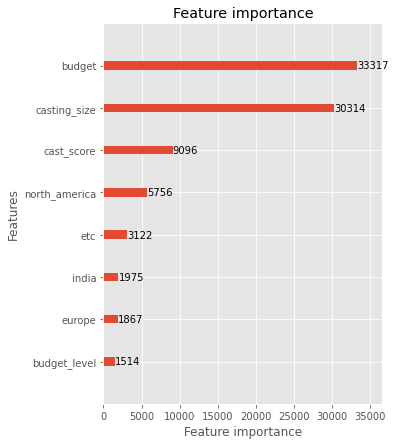

In [165]:
# 변수 중요도 확인 
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(figsize=(5,7))
plot_importance(lgb_model, ax=ax)

RandomRorest Regressor

In [167]:
#scale
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [0]:
X_scaled = scaler.transform(X)

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

rf = RandomForestRegressor(random_state=42)

param_rf = {
    'n_estimators': list(range(100, 501, 25)),
    'max_depth': list(range(5, 101, 5)),
    'min_samples_split': list(range(5, 101, 5)),
    'min_samples_leaf': list(range(5, 101, 5)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_leaf_nodes': list(range(5, 101, 5)),
    'bootstrap': [True]
}
random1 = RandomizedSearchCV(estimator=rf,
                            param_distributions=param_rf,
                            n_iter=1000,
                            n_jobs=-1,
                            cv=5,
                            random_state=42,
                            verbose=2)

In [170]:
# 학습
random1.fit(X_scaled, y)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 3277 tasks      | elapsed: 27.3min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 33.4min
[Parallel(n_jobs=-1)]: Done 4897 tasks      | elapsed: 40.8min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed: 41.6min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [0]:
#import joblib
#joblib.dump(random1, 'randomsearchcv_rf1.pkl')

In [172]:
random1.best_estimator_ #확인 

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=55,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=45, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [0]:
#GridSearch
rf1 = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': list(range(150, 201, 10)),
    'max_depth': [100],
    'min_samples_split': list(range(15, 26, 2)),
    'min_samples_leaf': list(range(5, 16, 2)),
    'max_features': ['sqrt'],
    'max_leaf_nodes': list(range(80, 91, 2)),
    'bootstrap': [True]
}

grid = GridSearchCV(estimator=rf1,
                    param_grid=param_grid,
                    n_jobs=-1,
                    cv=5,
                    verbose=2)

In [174]:
grid.fit(X, y)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 3277 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 4897 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 5828 tasks      | elapsed: 24.6min
[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed: 27.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, rand...
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,
    

In [175]:
grid.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features='sqrt', max_leaf_nodes=90,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=21, min_weight_fraction_leaf=0.0,
                      n_estimators=160, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [0]:
from sklearn.base import clone
new_rf = clone(grid.best_estimator_)

In [177]:
new_rf.fit(X, y) #학습

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features='sqrt', max_leaf_nodes=90,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=21, min_weight_fraction_leaf=0.0,
                      n_estimators=160, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [0]:
#예측
x_test_scaled = scaler.transform(df_test)
prediction2 = new_rf.predict(x_test_scaled)
final_pred = np.round(prediction2, 2)